In [1]:
from qspmodel import *
from chemo_qspmodel import *
import pandas as pd
import csv
import os
import scipy as sp

clustercells = pd.read_csv('input/TARGET_steady_states.csv')
clustercells.drop('Unnamed: 0', axis=1, inplace=True)
clustercells = clustercells.to_numpy()

meanvals = pd.read_csv('input/TARGET_avg_by_cluster.csv')
meanvals.drop('Unnamed: 0', axis=1, inplace=True)
meanvals = meanvals.to_numpy()

In [2]:
if not os.path.exists('Results/Vary_start_treatment/'):
     os.makedirs('Results/Vary_start_treatment/') 
        
# some global parameters
clusters=3 #number of clusters
cycle_time=35
n_cycles=2

# pre-defined parameters for treatment deltas, typical drug_dose
drug_deltas=[1.4466, 8.3178, 39.9253]
baseline_drug_dose=[381.90955, 1.19347, 1.90955]
drug_dose=[381.90955, 1.19347, 1.90955]

#other parameters
nvar=OS_MAP_Functions().nvar # number of variables
nparam=OS_MAP_Functions().nparam # number of parameters

In [3]:
def infusion(start_treatment):
    # create parameters for step function 
    A1infusion = [np.array([21, 127/6]),  np.array([28, 169/6])]
    A2infusion = [np.array([0, 1/6]), np.array([1, 7/6])]
    A3infusion = [np.array([0, 1/6]), np.array([1, 7/6])]
    infusion_idx = np.concatenate([15*np.ones(n_cycles*len(A1infusion)), 16*np.ones(n_cycles*len(A2infusion)), 
                                   17*np.ones(n_cycles*len(A3infusion))]).astype(int)

    infusion_vals = np.concatenate([(drug_dose[0]/baseline_drug_dose[0])*drug_deltas[0]/(A1infusion[0][1] - A1infusion[0][0])*np.ones(n_cycles*len(A1infusion)),
                                    (drug_dose[1]/baseline_drug_dose[1])*drug_deltas[1]/(A2infusion[0][1] - A2infusion[0][0])*np.ones(n_cycles*len(A2infusion)),
                                    (drug_dose[2]/baseline_drug_dose[2])*drug_deltas[2]/(A3infusion[0][1] - A3infusion[0][0])*np.ones(n_cycles*len(A3infusion))])

    infusion_intervals = np.concatenate([[start_treatment+i*cycle_time+j for i in range(n_cycles) for j in A1infusion],
                                         [start_treatment+i*cycle_time+j for i in range(n_cycles) for j in A2infusion],
                                         [start_treatment+i*cycle_time+j for i in range(n_cycles) for j in A3infusion]])
    
    return infusion_idx, infusion_vals, infusion_intervals

#### Plot cancer population after treatment with different treatment start times

In [7]:
def plot_vary_start_treatment(start_treatments, tumor_size, IC, T, y_UB):
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    import seaborn as sns
    
    betas = [2.4780, 1.8328, 0.1467]
    K_C = 0.9
    K_immune = 0.6
    a = 16
    alphaNCA = 0.8
    deltaCTcA3_scale = 1
    
    
    fig, axs = plt.subplots(1, len(start_treatments), sharey=False, figsize=(18,3))
    fig.subplots_adjust(wspace=0.3)
    axs = axs.flatten()
    t = np.linspace(0, T, 10*T+1)
    plt.rcParams.update({'font.size': 12.5})
    
    palette = {0:'#3F9B0B', 1:'#FF796C', 2:'#0343DF'}
    custom_lines = [Line2D([0], [0], color='#3F9B0B', lw=1.5),
                    Line2D([0], [0], color='#FF796C', lw=1.5),
                    Line2D([0], [0], color='#0343DF', lw=1.5)]
    
    for i, start_treatment in enumerate(start_treatments):
        print(start_treatment)
        infusion_idx, infusion_vals, infusion_intervals = infusion(start_treatment)
        r= step_vector(nvar, indices=infusion_idx, intervals=infusion_intervals, values=infusion_vals)
        
        for cluster in range(3):
            print(cluster)
            QSP0=QSP.from_cell_data(clustercells[cluster], meanvals[cluster])
            qspcore=OS_MAP_Functions(parameters=QSP0.par)
            deltaCTcA3 = QSP0.par[37]*deltaCTcA3_scale

            QSP_=QSP.from_data(([drug_deltas, betas, K_C, K_immune, a, alphaNCA, deltaCTcA3, baseline_drug_dose, 
                                 clustercells[cluster]]), qspcore=qspcore)

            dynamic_df = pd.DataFrame(columns=['time (days)', 'Cluster']+QSP_.variable_names())
            t = np.linspace(0, T, 10*T+1)
            dynamic_df['time (days)'] = t
            dynamic_df['Cluster'] = ['Cluster '+str(cluster+1)]*len(dynamic_df['time (days)'])

            u, _ = QSP_.solve_ode(t, IC[cluster], 'given', inhomogeneity=r, jumps=True)
            # Add last 3 equations scaling value
            scale = np.concatenate([clustercells[cluster], np.array(baseline_drug_dose)/np.array(drug_deltas)])
            u = scale*u
            t_after = 730+start_treatment*10
            print('Cancer after treatment: ', t_after, u[t_after][8])
            
            axs[i].margins(x=0)
            axs[i].yaxis.major.formatter._useMathText = True
            axs[i].plot(t, u[:,8], color=palette[cluster])
            axs[i].set_ylim(bottom=0, top=y_UB)
            axs[i].margins(y=0.2)

        axs[i].set_xlabel('time (days)')
        axs[i].set_ylabel('Cancer cells ($C$)')

    axs[0].legend(custom_lines, ['Cluster 1', 'Cluster 2', 'Cluster 3'], bbox_to_anchor=(-0.24, 0.5), loc='center right')
    
    fig.savefig('Figures/Vary_start_treatment_'+tumor_size+'_IC.png', bbox_inches='tight') 
    fig.savefig('Figures/Vary_start_treatment_'+tumor_size+'_IC.eps', bbox_inches='tight') 
    fig.savefig('Figures/Vary_start_treatment_'+tumor_size+'_IC.pdf', bbox_inches='tight') 
    plt.show()

#### Small tumors as initial conditions

In [5]:
small_IC=pd.read_csv('input/TARGET_nondimensional_initial_conditions.csv')
small_IC.drop('Unnamed: 0', axis=1, inplace=True)
small_IC = small_IC.to_numpy()
# Add 0 as initial drug concentrations to IC
small_IC = np.concatenate([small_IC, np.zeros((3,3))], axis=1)
small_IC

array([[2.36704151e+00, 1.00548860e+00, 1.88661156e-02, 7.93731766e-01,
        7.63946774e-01, 8.27810101e-01, 1.12204553e+00, 0.00000000e+00,
        2.01212968e-02, 1.59566607e-01, 2.39369964e+00, 1.10363881e+00,
        1.80579364e+00, 1.05943821e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [9.87532470e-01, 1.20294276e+00, 6.14106164e-01, 3.17899812e-01,
        2.69138566e+00, 1.82096094e+00, 7.26612875e-01, 0.00000000e+00,
        1.91311656e-02, 3.99676182e-01, 3.53394278e+00, 1.14354090e+00,
        1.43715069e+00, 1.11123637e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [8.65774071e-01, 1.10352852e+00, 5.71933607e-01, 3.39615677e-01,
        4.83925986e-01, 0.00000000e+00, 1.64261578e+00, 0.00000000e+00,
        1.43906276e-02, 8.38059744e-04, 2.76466391e-01, 1.02991955e+00,
        1.29642029e+00, 1.28390849e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

In [ ]:
plot_vary_start_treatment([7, 30, 90, 180], 'small', small_IC, 350, y_UB=2.2e+9)

7
0


C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Cancer after treatment:  800 76402459.08996609
1


#### Medium tumors as initial conditions

In [8]:
cols = ['Mn','M','Tn','Th','Tr','Tc','Dn','D', 'C', 'N', 'Ig', 'mu1', 'mu2', 'H', 'Cluster']

dat = pd.read_csv('input/TARGET_all_patients_data.csv')
dat.set_index('Unnamed: 0', inplace=True)
dat = dat[cols]
dat['Cluster'] = dat['Cluster'].apply(lambda x: int(x.split()[-1]) - 1)
dat.head()

,Mn,M,Tn,Th,Tr,Tc,Dn,D,C,N,Ig,mu1,mu2,H,Cluster
Unnamed: 0,,,,,,,,,,,,,,,
TARGET-40-0A4HLD,34722319.16,8.603081e+06,1.191137e+07,6.585836e+06,1.159015e+06,1.574469e+06,420744.0633,1.754688e+06,NaN,NaN,0.920293,30.230860,10.008177,5.153051,1
TARGET-40-0A4HMC,31258892.36,2.098196e+07,6.093952e+06,1.995128e+06,2.685176e+06,2.324501e+06,413314.7849,0.000000e+00,NaN,NaN,0.231310,23.827596,1.653993,5.337961,1
TARGET-40-0A4HX8,30996050.68,1.749005e+07,8.224196e+06,2.401357e+06,2.082830e+06,5.537368e+06,581007.0372,0.000000e+00,NaN,NaN,0.118360,21.778797,2.413981,5.286419,1
TARGET-40-0A4HXS,38114395.08,1.614895e+07,6.475678e+06,4.737582e+05,2.327004e+06,5.910068e+05,0.0000,0.000000e+00,NaN,NaN,0.111699,22.281144,2.132743,4.602700,1
TARGET-40-0A4HY5,44420404.14,9.428502e+06,1.308075e+07,1.000622e+05,3.088161e+05,0.000000e+00,0.0000,5.809818e+05,NaN,NaN,0.026163,30.262133,2.319897,4.919793,1


In [9]:
med_IC = np.empty((3,14))
for c in range(3):
    cluster_data = dat[dat.Cluster==c][dat.columns[:-1]]
    med_IC[c] = cluster_data.mean()
    print(c, med_IC[c][8])

0 6898651374.0
1 6956470086.953256
2 5048699653.61


In [10]:
med_IC = np.empty((3,14))
for c in range(3):
    cluster_data = dat[dat.Cluster==c][dat.columns[:-1]]
    med_IC[c] = cluster_data.mean()/clustercells[c]
    print(c, med_IC[c])
    
med_IC = np.concatenate([med_IC, np.zeros((3,3))], axis=1)
print(med_IC)

0 [2.80050327 0.91652038 1.42027592 0.52375538 0.69574304 0.49029249
 1.02024845 0.55901079 0.51361175 0.79647017 0.65496745 1.11992939
 1.16379098 0.99246719]
1 [1.00656314 0.93369284 0.98488638 0.96027687 1.45595791 2.15171979
 0.82022109 0.48773386 0.4337375  1.15243188 1.61858183 1.15704817
 1.3147215  0.99611916]
2 [1.27958286 0.98174536 0.72746934 1.01462199 0.90605062 0.58394159
 1.12483177 0.44319224 0.37686743 0.32670906 0.28975139 1.02107504
 1.43499545 1.07422225]
[[2.80050327 0.91652038 1.42027592 0.52375538 0.69574304 0.49029249
  1.02024845 0.55901079 0.51361175 0.79647017 0.65496745 1.11992939
  1.16379098 0.99246719 0.         0.         0.        ]
 [1.00656314 0.93369284 0.98488638 0.96027687 1.45595791 2.15171979
  0.82022109 0.48773386 0.4337375  1.15243188 1.61858183 1.15704817
  1.3147215  0.99611916 0.         0.         0.        ]
 [1.27958286 0.98174536 0.72746934 1.01462199 0.90605062 0.58394159
  1.12483177 0.44319224 0.37686743 0.32670906 0.28975139 1.02107

7
0


C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Cancer after treatment:  800 1411630737.581463
1
Cancer after treatment:  800 1269903780.6830637
2
Cancer after treatment:  800 754525004.4542135
30
0


C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Cancer after treatment:  1030 1531642688.4399633
1
Cancer after treatment:  1030 1367001503.9190092
2
Cancer after treatment:  1030 802427235.3662935
90
0


C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Cancer after treatment:  1630 1814136466.9496105
1
Cancer after treatment:  1630 1595587140.0950372
2
Cancer after treatment:  1630 919473566.1944082
180
0


C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Cancer after treatment:  2530 2115378706.2906344
1
Cancer after treatment:  2530 1898794173.6734233
2
Cancer after treatment:  2530 1086106057.1220598


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


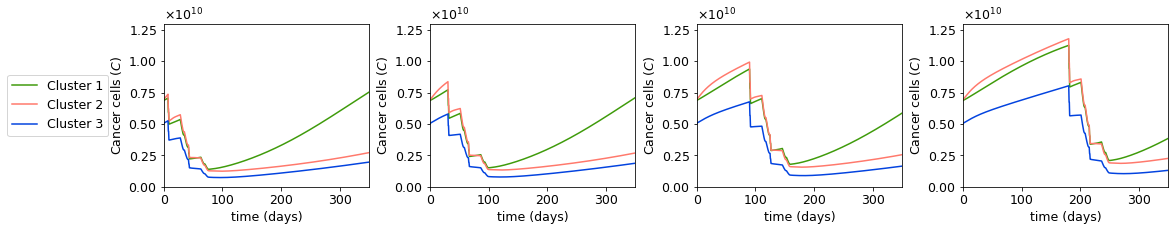

In [12]:
plot_vary_start_treatment([7, 30, 90, 180], 'medium', med_IC, 350, y_UB=1.3e+10)

#### Large tumors as initial conditions

7
0


C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Cancer after treatment:  800 2443836744.2144074
1
Cancer after treatment:  800 2603327887.331453
2
Cancer after treatment:  800 1873067364.2396274
30
0


C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Cancer after treatment:  1030 2442660526.616921
1
Cancer after treatment:  1030 2603926565.529454
2
Cancer after treatment:  1030 1868136382.425985
90
0


C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Cancer after treatment:  1630 2443647081.236478
1
Cancer after treatment:  1630 2599508471.6008697
2
Cancer after treatment:  1630 1865166629.738729
180
0


C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Cancer after treatment:  2530 2435813825.3614907
1
Cancer after treatment:  2530 2595772204.6654334
2
Cancer after treatment:  2530 1868301880.9204216


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


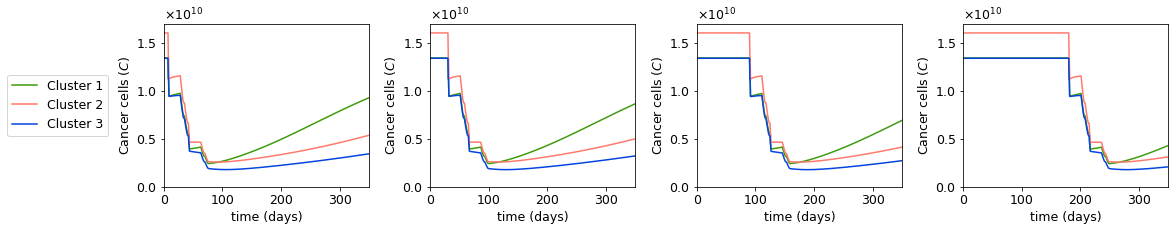

In [13]:
large_IC = np.ones((clusters,nvar))
large_IC[:,-3:] = 0

plot_vary_start_treatment([7, 30, 90, 180], 'large', large_IC, 350, y_UB=1.7e+10)